# 공실률 & 임대료 EDA


## 라이브러리 임포트


In [1]:
import os
import psycopg2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/share/fonts: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/urw-base35: caching, new cache contents: 35 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/droid: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts

## 데이터 불러오기


**데이터**

- 상권, 임대료, 공실률 데이터를 사용
- 매장용빌딩 공실률과 읍면동별 스크래핑한 임대료 데이터를 사용하여 분석 중 **소규모 상가, 중대형 상가, 집합 상가별**로 나눠져 있는 공실률, 임대료 데이터를 발견해서 그 데이터로 다시 EDA를 진행하였다.
- 임대료 산정 시, 상가는 가장 효율적으로 이용되고 있는 1층을 기준으로 산정한 데이터

> **평당 임대료 vs ㎡당 임대료** <br>
> 평당 임대료는 1평(3.3㎡)을 기준으로 계산한 임대료이다. 예를 들어, 평당 10만 원이면, 10평(33㎡) 매장의 임대료는 100만원이다. ㎡당 임대료는 1㎡ 기준으로 계산한 임대료이다. 예를 들어, ㎡당 3만 원이면, 10㎡ 매장의 임대료는 30만 원이다. 현재 볼 데이터는 **㎡당 임대료**이다.


In [3]:
# 환경 변수 로드
load_dotenv()

# DB 구성 객체
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', 5432),
    'database': os.getenv('DB_NAME', 'postgres'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'postgres')
}

In [4]:
conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    port=DB_CONFIG['port'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    client_encoding='UTF8'
)

if conn is None:
  print("Connection failed")

### 임대료 및 공실률 데이터 로드


In [5]:
df_origin_v_rate_s_2022 = pd.read_sql("SELECT * FROM v_rate.v_rate_by_region_from_2022_s", conn)  # 공실률 - 소규모 (2022 ~)
df_origin_v_rate_ml_2022 = pd.read_sql("SELECT * FROM v_rate.v_rate_by_region_from_2022_ml", conn)  # 공실률 - 중대형 (2022 ~)
df_origin_v_rate_g_2022 = pd.read_sql("SELECT * FROM v_rate.v_rate_by_region_from_2022_g", conn)  # 공실률 - 집합 (2022 ~)
df_origin_v_rate_s_2024q3 = pd.read_sql("SELECT * FROM v_rate.v_rate_by_region_from_2024q3_s", conn)  # 공실률 - 소규모 (2024-Q3 ~)
df_origin_v_rate_ml_2024q3 = pd.read_sql("SELECT * FROM v_rate.v_rate_by_region_from_2024q3_ml", conn)  # 공실률 - 중대형 (2024-Q3 ~)
df_origin_v_rate_g_2024q3 = pd.read_sql("SELECT * FROM v_rate.v_rate_by_region_from_2024q3_g", conn)  # 공실률 - 집합 (2024-Q3 ~)

In [6]:
df_v_rate_s_2022 = pd.json_normalize(df_origin_v_rate_s_2022['data'].tolist())
df_v_rate_ml_2022 = pd.json_normalize(df_origin_v_rate_ml_2022['data'].tolist())
df_v_rate_g_2022 = pd.json_normalize(df_origin_v_rate_g_2022['data'].tolist())
df_v_rate_s_2024q3 = pd.json_normalize(df_origin_v_rate_s_2024q3['data'].tolist())
df_v_rate_ml_2024q3 = pd.json_normalize(df_origin_v_rate_ml_2024q3['data'].tolist())
df_v_rate_g_2024q3 = pd.json_normalize(df_origin_v_rate_g_2024q3['data'].tolist())

In [7]:
df_origin_rent_s_2022 = pd.read_sql("SELECT * FROM rent.rent_by_region_from_2022_s", conn)  # 임대료 - 소규모 (2022 ~)
df_origin_rent_ml_2022 = pd.read_sql("SELECT * FROM rent.rent_by_region_from_2022_ml", conn)  # 임대료 - 중대형 (2022 ~)
df_origin_rent_g_2022 = pd.read_sql("SELECT * FROM rent.rent_by_region_from_2022_g", conn)  # 임대료 - 집합 (2022 ~)
df_origin_rent_s_2024q3 = pd.read_sql("SELECT * FROM rent.rent_by_region_from_2024q3_s", conn)  # 임대료 - 소규모 (2024-Q3 ~)
df_origin_rent_ml_2024q3 = pd.read_sql("SELECT * FROM rent.rent_by_region_from_2024q3_ml", conn)  # 임대료 - 중대형 (2024-Q3 ~)
df_origin_rent_g_2024q3 = pd.read_sql("SELECT * FROM rent.rent_by_region_from_2024q3_g", conn)  # 임대료 - 집합 (2024-Q3 ~)

In [8]:
df_rent_s_2022 = pd.json_normalize(df_origin_rent_s_2022['data'].tolist())
df_rent_ml_2022 = pd.json_normalize(df_origin_rent_ml_2022['data'].tolist())
df_rent_g_2022 = pd.json_normalize(df_origin_rent_g_2022['data'].tolist())
df_rent_s_2024q3 = pd.json_normalize(df_origin_rent_s_2024q3['data'].tolist())
df_rent_ml_2024q3 = pd.json_normalize(df_origin_rent_ml_2024q3['data'].tolist())
df_rent_g_2024q3 = pd.json_normalize(df_origin_rent_g_2024q3['data'].tolist())

## 데이터 전처리


In [9]:
df_v_rate_s_2022.head()

,행번,대분류,중분류,소분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기
0,1,서울,도심,광화문,12.65,0.64,0.00,0.00,0.00,5.14,5.14,0.00,0.00,0.00
1,2,서울,도심,남대문,6.93,6.93,6.93,8.23,8.23,8.90,7.60,9.61,9.61,9.61
2,3,서울,도심,동대문,3.38,3.38,3.38,4.41,4.41,5.55,4.70,7.79,11.97,11.97
3,4,서울,도심,명동,42.10,36.94,36.94,21.53,21.53,19.66,19.66,19.66,1.79,2.39
4,5,서울,도심,시청,5.64,5.64,3.46,6.91,3.46,5.43,4.36,4.27,4.27,4.27


In [10]:
df_v_rate_s_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   행번        54 non-null     object
 1   대분류       54 non-null     object
 2   중분류       54 non-null     object
 3   소분류       54 non-null     object
 4   2022년1분기  54 non-null     object
 5   2022년2분기  54 non-null     object
 6   2022년3분기  54 non-null     object
 7   2022년4분기  54 non-null     object
 8   2023년1분기  54 non-null     object
 9   2023년2분기  54 non-null     object
 10  2023년3분기  54 non-null     object
 11  2023년4분기  54 non-null     object
 12  2024년1분기  54 non-null     object
 13  2024년2분기  54 non-null     object
dtypes: object(14)
memory usage: 6.0+ KB


In [11]:
drop_rows = ['도심', '강남', '서울', '영등포신촌', '기타']

In [12]:
small_vacancy_df = df_v_rate_s_2022.copy()
small_vacancy_df.drop(columns=['행번', '대분류', '중분류'], inplace=True)
small_vacancy_df = small_vacancy_df.rename(columns={
    '소분류': '분류',
})
# 공백은 _로 바꾸기
small_vacancy_df.columns = small_vacancy_df.columns.str.replace(' ', '_', regex=True)
small_vacancy_df = small_vacancy_df[~small_vacancy_df['분류'].isin(drop_rows)]
small_vacancy_df.reset_index(drop=True, inplace=True)

numeric_columns = [col for col in small_vacancy_df.columns if col != '분류']
for col in numeric_columns:
  small_vacancy_df[col] = pd.to_numeric(small_vacancy_df[col], errors='coerce')

small_vacancy_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기
0,광화문,12.65,0.64,0.00,0.00,0.00,5.14,5.14,0.00,0.00,0.00
1,남대문,6.93,6.93,6.93,8.23,8.23,8.90,7.60,9.61,9.61,9.61
2,동대문,3.38,3.38,3.38,4.41,4.41,5.55,4.70,7.79,11.97,11.97
3,명동,42.10,36.94,36.94,21.53,21.53,19.66,19.66,19.66,1.79,2.39
4,시청,5.64,5.64,3.46,6.91,3.46,5.43,4.36,4.27,4.27,4.27


In [13]:
df_v_rate_s_2024q3.head()

,행번,대분류,중분류,소분류,2024년3분기,2024년4분기
0,1,서울,도심,광화문,0.94,0.94
1,2,서울,도심,남대문,6.21,14.05
2,3,서울,도심,동대문,11.73,11.73
3,4,서울,도심,명동,2.39,2.39
4,5,서울,도심,방산시장,4.99,4.99


In [14]:
small_vacancy_df_2 = df_v_rate_s_2024q3.copy()
small_vacancy_df_2.drop(columns=['행번', '대분류', '중분류'], inplace=True)
small_vacancy_df_2 = small_vacancy_df_2.rename(columns={
    '소분류': '분류',
})
# 공백은 _로 바꾸기
small_vacancy_df_2.columns = small_vacancy_df_2.columns.str.replace(' ', '_', regex=True)
small_vacancy_df_2 = small_vacancy_df_2[~small_vacancy_df_2['분류'].isin(drop_rows)]
small_vacancy_df_2.reset_index(drop=True, inplace=True)

numeric_columns = [col for col in small_vacancy_df_2.columns if col != '분류']
for col in numeric_columns:
  small_vacancy_df_2[col] = pd.to_numeric(small_vacancy_df_2[col], errors='coerce')

small_vacancy_df_2.head()

,분류,2024년3분기,2024년4분기
0,광화문,0.94,0.94
1,남대문,6.21,14.05
2,동대문,11.73,11.73
3,명동,2.39,2.39
4,방산시장,4.99,4.99


In [15]:
small_vacancy_df = small_vacancy_df.merge(small_vacancy_df_2, on='분류', how='outer')
small_vacancy_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
0,가락시장,0.00,0.00,2.17,2.17,2.17,0.00,0.00,2.17,2.17,0.00,17.18,0.0
1,강남대로,22.02,2.03,8.58,0.00,0.00,0.00,0.00,0.00,0.00,11.02,0.00,0.0
2,건대입구,0.00,8.84,13.17,9.94,4.33,4.33,4.33,0.00,0.00,0.00,0.00,0.0
3,경희대,0.00,3.31,3.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,공덕역,0.97,2.63,5.11,0.96,0.96,0.96,2.95,0.96,0.96,0.96,1.10,1.1


In [16]:
small_vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   분류        59 non-null     object 
 1   2022년1분기  54 non-null     float64
 2   2022년2분기  54 non-null     float64
 3   2022년3분기  54 non-null     float64
 4   2022년4분기  54 non-null     float64
 5   2023년1분기  54 non-null     float64
 6   2023년2분기  54 non-null     float64
 7   2023년3분기  54 non-null     float64
 8   2023년4분기  54 non-null     float64
 9   2024년1분기  54 non-null     float64
 10  2024년2분기  54 non-null     float64
 11  2024년3분기  59 non-null     float64
 12  2024년4분기  59 non-null     float64
dtypes: float64(12), object(1)
memory usage: 6.1+ KB


In [17]:
small_vacancy_df.loc[small_vacancy_df['2022년1분기'].isna()]

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
8,까치산역,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,3.66
23,방산시장,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.99,4.99
24,북촌,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.90,10.07
30,서촌,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.03,7.79
39,약수역,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.99,7.99


In [18]:
df_v_rate_ml_2022.head(10)

,행번,대분류,중분류,소분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기
0,1,서울,서울,서울,9.50,9.53,9.10,9.06,8.57,8.44,8.79,8.38,8.43,8.51
1,2,서울,도심,도심,16.16,16.87,18.06,18.28,15.97,15.34,14.58,14.07,14.04,13.09
2,3,서울,도심,광화문,18.06,14.93,16.78,17.24,16.59,17.98,16.47,13.51,16.64,16.64
3,4,서울,도심,남대문,13.63,13.63,13.63,12.62,9.69,9.69,9.69,10.13,10.69,8.68
4,5,서울,도심,동대문,10.89,10.66,12.13,11.75,13.52,12.67,12.54,12.12,13.59,11.31
5,6,서울,도심,명동,40.87,40.87,43.02,43.52,37.59,35.85,31.32,27.73,22.35,22.57
6,7,서울,도심,시청,11.18,17.53,17.53,17.53,16.57,16.76,19.88,19.88,21.67,19.82
7,8,서울,도심,을지로,8.90,8.90,16.54,15.11,15.11,15.11,15.11,21.20,21.20,21.20
8,9,서울,도심,종로,10.67,12.21,12.07,13.50,9.48,7.99,7.31,7.31,7.31,6.74
9,10,서울,도심,충무로,9.82,11.10,11.10,11.10,7.73,7.73,7.73,7.95,7.95,7.95


In [19]:
# 함수로 만들기
def process_data(df):
  df_processed = df.copy()
  df_processed.drop(columns=['행번', '대분류', '중분류'], inplace=True)
  df_processed = df_processed.rename(columns={
      '소분류': '분류',
  })
  # 공백은 _로 바꾸기
  df_processed.columns = df_processed.columns.str.replace(' ', '_', regex=True)
  df_processed = df_processed[~df_processed['분류'].isin(drop_rows)]
  df_processed.reset_index(drop=True, inplace=True)
  numeric_columns = [col for col in df_processed.columns if col != '분류']
  for col in numeric_columns:
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
  df_processed.head()
  return df_processed

def merge_data(df1, df2):
  df_processed = df1.merge(df2, on='분류', how='outer')
  return df_processed

In [20]:
df1 = process_data(df_v_rate_ml_2022)
df2 = process_data(df_v_rate_ml_2024q3)

In [21]:
big_vacancy_df = merge_data(df1, df2)
big_vacancy_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
0,가락시장,6.90,8.92,9.36,11.46,10.45,9.09,9.09,9.09,10.72,10.72,12.12,12.06
1,강남대로,13.08,13.38,12.00,10.82,11.56,11.49,9.95,8.26,8.11,9.54,10.30,12.08
2,건대입구,4.80,5.40,4.41,4.41,7.83,9.14,9.81,9.26,9.91,10.34,7.74,7.21
3,경희대,2.96,2.70,2.70,2.51,4.17,6.55,6.73,6.62,5.66,4.22,4.93,3.02
4,공덕역,6.70,6.70,6.70,6.70,6.70,6.70,6.70,6.70,8.34,9.98,7.40,8.72


In [22]:
big_vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   분류        68 non-null     object 
 1   2022년1분기  61 non-null     float64
 2   2022년2분기  61 non-null     float64
 3   2022년3분기  61 non-null     float64
 4   2022년4분기  61 non-null     float64
 5   2023년1분기  61 non-null     float64
 6   2023년2분기  61 non-null     float64
 7   2023년3분기  61 non-null     float64
 8   2023년4분기  61 non-null     float64
 9   2024년1분기  61 non-null     float64
 10  2024년2분기  61 non-null     float64
 11  2024년3분기  68 non-null     float64
 12  2024년4분기  68 non-null     float64
dtypes: float64(12), object(1)
memory usage: 7.0+ KB


In [23]:
big_vacancy_df.loc[big_vacancy_df['2022년1분기'].isna()]

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
10,까치산역,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.10,6.67
11,낙성대,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.42,6.38
27,방산시장,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.44,14.05
28,북촌,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.17,6.17
35,서촌,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.20,15.98
43,쌍문역,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.48,13.07
45,약수역,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.99,2.99


In [24]:
# 집합 상가 데이터는 2022년 4분기 데이터밖에 없다.
df_v_rate_g_2022.head()

,행번,대분류,중분류,소분류,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기
0,1,서울,서울,서울,8.14,8.01,8.26,8.34,9.15,9.28,9.51
1,2,서울,도심,도심,10.12,10.11,11.05,11.10,11.10,11.10,11.19
2,3,서울,도심,남대문,1.70,1.40,1.37,1.37,1.37,1.37,1.37
3,4,서울,도심,동대문,12.10,12.11,12.14,12.14,12.14,12.14,12.16
4,5,서울,도심,을지로,9.07,9.07,9.07,10.31,10.31,10.31,11.43


In [25]:
# 2022년 1분기, 2022년 2분기, 2022년 3분기 컬럼 추가하기
df_v_rate_g_2022.insert(4, '2022년1분기', np.nan)
df_v_rate_g_2022.insert(5, '2022년2분기', np.nan)
df_v_rate_g_2022.insert(6, '2022년3분기', np.nan)

In [26]:
df_v_rate_g_2022.head()

,행번,대분류,중분류,소분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기
0,1,서울,서울,서울,NaN,NaN,NaN,8.14,8.01,8.26,8.34,9.15,9.28,9.51
1,2,서울,도심,도심,NaN,NaN,NaN,10.12,10.11,11.05,11.10,11.10,11.10,11.19
2,3,서울,도심,남대문,NaN,NaN,NaN,1.70,1.40,1.37,1.37,1.37,1.37,1.37
3,4,서울,도심,동대문,NaN,NaN,NaN,12.10,12.11,12.14,12.14,12.14,12.14,12.16
4,5,서울,도심,을지로,NaN,NaN,NaN,9.07,9.07,9.07,10.31,10.31,10.31,11.43


In [27]:
df_v_rate_g_2024q3.head()

,행번,대분류,중분류,소분류,2024년3분기,2024년4분기
0,1,서울,서울,서울,9.14,9.08
1,2,서울,도심,도심,10.94,10.84
2,3,서울,도심,남대문,1.33,1.33
3,4,서울,도심,동대문,12.15,11.90
4,5,서울,도심,방산시장,8.32,8.56


In [28]:
df1 = process_data(df_v_rate_g_2022)
df2 = process_data(df_v_rate_g_2024q3)

complex_vacancy_df = merge_data(df1, df2)
complex_vacancy_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
0,가락시장,NaN,NaN,NaN,17.15,17.74,17.74,17.74,17.74,17.74,17.74,17.98,17.98
1,강남대로,NaN,NaN,NaN,3.55,4.17,5.45,7.58,11.22,10.94,10.94,9.01,8.54
2,건대입구,NaN,NaN,NaN,7.49,7.98,4.63,4.85,8.51,16.89,8.77,9.00,8.73
3,교대역,NaN,NaN,NaN,2.13,0.56,1.12,1.12,1.12,1.12,1.12,1.12,1.12
4,남대문,NaN,NaN,NaN,1.70,1.40,1.37,1.37,1.37,1.37,1.37,1.33,1.33


In [29]:
# NaN 처리하는 함수 만들기
def process_nan(df):
  # NaN 값을 오른쪽 값으로 채우기
  df = df.bfill(axis=1)

  # 나머지 NaN 값은 왼쪽 값으로 채우기
  df = df.ffill(axis=1)

  return df

In [30]:
small_vacancy_df = process_nan(small_vacancy_df)
big_vacancy_df = process_nan(big_vacancy_df)
complex_vacancy_df = process_nan(complex_vacancy_df)

/tmp/ipykernel_79767/1730474830.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill(axis=1)
/tmp/ipykernel_79767/1730474830.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill(axis=1)
/tmp/ipykernel_79767/1730474830.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill(axis=1)


In [31]:
display(small_vacancy_df.isna().sum())
display(big_vacancy_df.isna().sum())
display(complex_vacancy_df.isna().sum())

분류          0
2022년1분기    0
2022년2분기    0
2022년3분기    0
2022년4분기    0
2023년1분기    0
2023년2분기    0
2023년3분기    0
2023년4분기    0
2024년1분기    0
2024년2분기    0
2024년3분기    0
2024년4분기    0
dtype: int64

분류          0
2022년1분기    0
2022년2분기    0
2022년3분기    0
2022년4분기    0
2023년1분기    0
2023년2분기    0
2023년3분기    0
2023년4분기    0
2024년1분기    0
2024년2분기    0
2024년3분기    0
2024년4분기    0
dtype: int64

분류          0
2022년1분기    0
2022년2분기    0
2022년3분기    0
2022년4분기    0
2023년1분기    0
2023년2분기    0
2023년3분기    0
2023년4분기    0
2024년1분기    0
2024년2분기    0
2024년3분기    0
2024년4분기    0
dtype: int64

In [32]:
complex_vacancy_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
0,가락시장,17.15,17.15,17.15,17.15,17.74,17.74,17.74,17.74,17.74,17.74,17.98,17.98
1,강남대로,3.55,3.55,3.55,3.55,4.17,5.45,7.58,11.22,10.94,10.94,9.01,8.54
2,건대입구,7.49,7.49,7.49,7.49,7.98,4.63,4.85,8.51,16.89,8.77,9.00,8.73
3,교대역,2.13,2.13,2.13,2.13,0.56,1.12,1.12,1.12,1.12,1.12,1.12,1.12
4,남대문,1.70,1.70,1.70,1.70,1.40,1.37,1.37,1.37,1.37,1.37,1.33,1.33


In [33]:
df_rent_s_2022.head()

,행번,대분류,중분류,소분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기
0,1,서울,서울,서울,48.96,49.09,49.18,48.89,49.05,49.21,49.52,49.71,49.90,50.13
1,2,서울,도심,도심,65.86,65.93,66.15,65.92,66.13,66.40,66.83,67.21,67.45,67.74
2,3,서울,도심,광화문,81.43,81.52,81.77,82.53,83.12,82.47,83.02,83.17,83.78,84.14
3,4,서울,도심,남대문,62.39,62.55,63.18,63.24,63.33,63.87,64.03,64.28,64.56,66.15
4,5,서울,도심,동대문,47.53,47.61,47.57,47.34,47.23,47.81,48.00,48.00,48.15,48.89


In [34]:
df1 = process_data(df_rent_s_2022)
df2 = process_data(df_rent_s_2024q3)

small_rent_df = merge_data(df1, df2)
small_rent_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
0,가락시장,31.06,31.08,31.08,31.04,30.98,30.79,30.74,30.73,30.73,30.71,31.26,31.08
1,강남대로,102.78,103.10,103.01,84.98,85.18,85.54,85.70,86.25,86.37,86.82,80.25,80.34
2,건대입구,46.39,46.58,46.52,46.48,46.46,46.44,46.50,46.72,46.68,46.52,50.43,50.42
3,경희대,45.40,45.34,45.56,45.79,45.85,46.10,46.42,46.67,46.75,46.85,47.51,47.40
4,공덕역,59.48,59.62,59.67,59.95,60.12,60.22,60.40,60.56,60.85,61.09,59.00,59.16


In [35]:
df1 = process_data(df_rent_ml_2022)
df2 = process_data(df_rent_ml_2024q3)

big_rent_df = merge_data(df1, df2)
big_rent_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
0,가락시장,39.00,39.03,39.02,38.48,38.51,38.53,38.48,38.49,38.50,38.48,38.57,38.57
1,강남대로,105.81,106.12,106.48,106.18,106.87,106.99,107.38,106.90,107.04,107.61,116.82,116.96
2,건대입구,69.02,69.27,69.17,69.11,69.07,69.04,69.08,68.85,68.67,68.48,65.51,65.49
3,경희대,48.88,48.87,48.95,49.11,49.19,49.30,49.66,49.75,49.86,49.97,48.64,48.42
4,공덕역,38.87,38.95,38.99,39.02,39.11,39.15,39.28,39.35,39.46,39.64,39.67,39.69


In [36]:
df1 = process_data(df_rent_g_2022)
df2 = process_data(df_rent_g_2024q3)

complex_rent_df = merge_data(df1, df2)
complex_rent_df.head()

,분류,2022년1분기,2022년2분기,2022년3분기,2022년4분기,2023년1분기,2023년2분기,2023년3분기,2023년4분기,2024년1분기,2024년2분기,2024년3분기,2024년4분기
0,가락시장,24.81,24.81,24.83,24.84,25.07,25.30,25.30,25.31,25.32,25.30,30.70,30.66
1,강남대로,72.65,72.65,72.61,75.94,75.67,75.71,76.16,76.45,76.42,76.91,82.04,82.45
2,건대입구,68.86,69.01,68.95,68.91,68.90,68.90,68.90,68.81,68.79,68.78,68.70,68.67
3,교대역,41.93,42.01,42.05,41.96,42.19,42.31,42.32,42.34,42.37,42.41,42.27,42.28
4,남대문,177.30,177.39,177.55,177.32,177.43,177.58,177.80,178.04,178.64,179.38,188.15,188.19


In [37]:
small_rent_df = process_nan(small_rent_df)
big_rent_df = process_nan(big_rent_df)
complex_rent_df = process_nan(complex_rent_df)

/tmp/ipykernel_79767/1730474830.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill(axis=1)
/tmp/ipykernel_79767/1730474830.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill(axis=1)
/tmp/ipykernel_79767/1730474830.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill(axis=1)


In [38]:
display(small_rent_df.isna().sum())
display(big_rent_df.isna().sum())
display(complex_rent_df.isna().sum())

분류          0
2022년1분기    0
2022년2분기    0
2022년3분기    0
2022년4분기    0
2023년1분기    0
2023년2분기    0
2023년3분기    0
2023년4분기    0
2024년1분기    0
2024년2분기    0
2024년3분기    0
2024년4분기    0
dtype: int64

분류          0
2022년1분기    0
2022년2분기    0
2022년3분기    0
2022년4분기    0
2023년1분기    0
2023년2분기    0
2023년3분기    0
2023년4분기    0
2024년1분기    0
2024년2분기    0
2024년3분기    0
2024년4분기    0
dtype: int64

분류          0
2022년1분기    0
2022년2분기    0
2022년3분기    0
2022년4분기    0
2023년1분기    0
2023년2분기    0
2023년3분기    0
2023년4분기    0
2024년1분기    0
2024년2분기    0
2024년3분기    0
2024년4분기    0
dtype: int64

## 데이터 분석


- 2022년~2024년 분기별로 공실률과 임대료를 같이 확인해보자.
- 공실률이 높으면, 임대료도 높을까?
- 공실률이 높으면 젠트리피케이션 위험 지역일까?
- 임대료가 높으면 젠트리피케이션 위험 지역일까?


In [39]:
small_vacancy_df['분류'].unique()

array(['가락시장', '강남대로', '건대입구', '경희대', '공덕역', '광화문', '교대역', '군자', '까치산역',
       '남대문', '남부터미널', '노량진', '논현역', '당산역', '도산대로', '독산/시흥', '동교/연남',
       '동대문', '뚝섬', '망원역', '명동', '목동', '미아사거리', '방산시장', '북촌', '불광역', '사당',
       '상계역', '상봉역', '서울대입구역', '서촌', '성신여대', '수유', '숙명여대', '시청', '신림역',
       '신사역', '신촌/이대', '압구정', '약수역', '연신내', '영등포역', '오류동역', '왕십리', '용산역',
       '을지로', '이태원', '잠실/송파', '잠실새내역', '장안동', '종로', '천호', '청담', '청량리',
       '충무로', '테헤란로', '혜화동', '홍대/합정', '화곡'], dtype=object)

In [40]:
big_vacancy_df['분류'].unique()

array(['가락시장', '강남대로', '건대입구', '경희대', '공덕역', '광화문', '교대역', '구로디지털단지역',
       '구의역', '군자', '까치산역', '낙성대', '남대문', '남부터미널', '노량진', '논현역', '당산역',
       '도산대로', '독산/시흥', '동교/연남', '동대문', '뚝섬', '망원역', '명동', '목동', '미아사거리',
       '방배역/내방역', '방산시장', '북촌', '불광역', '사당', '상계역', '상봉역', '서래마을',
       '서울대입구역', '서촌', '성신여대', '수유', '숙명여대', '시청', '신림역', '신사역', '신촌/이대',
       '쌍문역', '압구정', '약수역', '양재말죽거리', '양재역', '연신내', '영등포역', '오류동역', '왕십리',
       '용산역', '을지로', '이태원', '잠실/송파', '잠실새내역', '장안동', '종로', '천호', '청담',
       '청량리', '충무로', '테헤란로', '학동/강남구청역', '혜화동', '홍대/합정', '화곡'],
      dtype=object)

In [41]:
complex_vacancy_df['분류'].unique()

array(['가락시장', '강남대로', '건대입구', '교대역', '남대문', '남부터미널', '노원역', '논현역', '당산역',
       '도산대로', '동대문', '명일역', '목동', '방산시장', '불광역', '사당', '서울대입구역', '성신여대',
       '수유', '숙명여대', '신림역', '신사역', '신촌/이대', '압구정', '여의도', '영등포역', '오류동역',
       '용산역', '을지로', '잠실/송파', '잠실새내역', '장안동', '종로', '천호', '청담', '청량리',
       '테헤란로', '한티역', '혜화동', '홍대/합정', '화곡'], dtype=object)

In [42]:
quarters = [col for col in small_rent_df.columns if '년' in col]
small_vacancy_df[small_vacancy_df['분류'] == '명동'][quarters].values.flatten()

array([42.1 , 36.94, 36.94, 21.53, 21.53, 19.66, 19.66, 19.66,  1.79,
        2.39,  2.39,  2.39])

In [43]:
# 시각화할 때, 공실률이 object라서 y축이 뒤죽박죽 -> float으로 바꿔주기
def convert_to_float(df):
  df[quarters] = df[quarters].astype(float)
  return df

small_vacancy_df = convert_to_float(small_vacancy_df)
big_vacancy_df = convert_to_float(big_vacancy_df)
complex_vacancy_df = convert_to_float(complex_vacancy_df)

small_rent_df = convert_to_float(small_rent_df)
big_rent_df = convert_to_float(big_rent_df)
complex_rent_df = convert_to_float(complex_rent_df)

In [44]:
big_rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   분류        68 non-null     object 
 1   2022년1분기  68 non-null     float64
 2   2022년2분기  68 non-null     float64
 3   2022년3분기  68 non-null     float64
 4   2022년4분기  68 non-null     float64
 5   2023년1분기  68 non-null     float64
 6   2023년2분기  68 non-null     float64
 7   2023년3분기  68 non-null     float64
 8   2023년4분기  68 non-null     float64
 9   2024년1분기  68 non-null     float64
 10  2024년2분기  68 non-null     float64
 11  2024년3분기  68 non-null     float64
 12  2024년4분기  68 non-null     float64
dtypes: float64(12), object(1)
memory usage: 7.0+ KB


In [45]:
# 명동 스케일이 너무 커서 다른 그래프가 잘 보이지 않는 경향을 보임
small_vacancy_without_mang = small_vacancy_df[small_vacancy_df['분류'] != '명동']
big_vacancy_without_mang = big_vacancy_df[big_vacancy_df['분류'] != '명동']
small_rent_df_without_mang = small_rent_df[small_rent_df['분류'] != '명동']
big_rent_df_without_mang = big_rent_df[big_rent_df['분류'] != '명동']

small_vacancy_df_numeric = small_vacancy_without_mang.select_dtypes(include=['float64'])
big_vacancy_df_numeric = big_vacancy_without_mang.select_dtypes(include=['float64'])

small_rent_df_numeric = small_rent_df_without_mang.select_dtypes(include=['float64'])
big_rent_df_numeric = big_rent_df_without_mang.select_dtypes(include=['float64'])

vacancy_min = min(small_vacancy_df_numeric.min().min(), small_vacancy_df_numeric.min().min())
vacancy_max = max(small_vacancy_df_numeric.max().max(), small_vacancy_df_numeric.max().max())

# 임대료는 소규모상가 따로, 중대형 상가 따로
# 같이 y축으로 두니까 눈금 20씩이라서 소규모상가 임대료 추이가 제대로 보이지않음
rent_small_min = small_rent_df_numeric.min().min()
rent_small_max = small_rent_df_numeric.max().max()
rent_big_min = big_rent_df_numeric.min().min()
rent_big_max = big_rent_df_numeric.max().max()

In [46]:
# 지역별로 소규모/중대형/집합 상가의 공실률과 임대료를 시각화하는 함수
from matplotlib.ticker import MultipleLocator

def visualize_by_region(region):
  # 2022년 1분기 ~ 2024년 4분기 컬럼만 추출
  quarters = [col for col in small_rent_df.columns if '년' in col]

  # 각 데이터프레임에서 해당 지역 데이터 필터링
  small_vacancy_region = small_vacancy_df[small_vacancy_df['분류'] == region][quarters].values.flatten()
  big_vacancy_region = big_vacancy_df[big_vacancy_df['분류'] == region][quarters].values.flatten()

  small_rent_region = small_rent_df[small_rent_df['분류'] == region][quarters].values.flatten()
  big_rent_region = big_rent_df[big_rent_df['분류'] == region][quarters].values.flatten()

  # x축 레이블
  x_labels = [f"{q.split('년')[0]}Q{q.split('년')[1][0]}" for q in quarters]

  # 그래프 그리기
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))

  # 소규모 상가 공실률 그래프
  axes[0, 0].plot(x_labels, small_vacancy_region, 'b-o', label='소규모 상가')
  axes[0, 0].set_title(f'{region} 지역 소규모 상가 공실률', fontsize=14)
  axes[0, 0].set_xlabel('분기', fontsize=12)
  axes[0, 0].set_ylabel('공실률 (%)', fontsize=12)
  axes[0, 0].grid(True, alpha=0.3)
  axes[0, 0].legend()
  axes[0, 0].tick_params(axis='x', rotation=45)
  if region != '명동':
    axes[0, 0].set_ylim(vacancy_min, vacancy_max)  # y축 범위 설정

  # 중대형 상가 공실률 그래프
  axes[0, 1].plot(x_labels, big_vacancy_region, 'r-s', label='중대형 상가')
  axes[0, 1].set_title(f'{region} 지역 중대형 상가 공실률', fontsize=14)
  axes[0, 1].set_xlabel('분기', fontsize=12)
  axes[0, 1].set_ylabel('공실률 (%)', fontsize=12)
  axes[0, 1].grid(True, alpha=0.3)
  axes[0, 1].legend()
  axes[0, 1].tick_params(axis='x', rotation=45)
  if region != '명동':
    axes[0, 1].set_ylim(vacancy_min, vacancy_max)  # y축 범위 설정

  # 소규모 상가 임대료 그래프
  axes[1, 0].plot(x_labels, small_rent_region, 'b-o', label='소규모 상가')
  axes[1, 0].set_title(f'{region} 지역 소규모 상가 임대료', fontsize=14)
  axes[1, 0].set_xlabel('분기', fontsize=12)
  axes[1, 0].set_ylabel('임대료', fontsize=12)
  axes[1, 0].grid(True, alpha=0.3)
  axes[1, 0].legend()
  axes[1, 0].tick_params(axis='x', rotation=45)
  if region != '명동':
    axes[1, 0].set_ylim(rent_small_min, rent_small_max)  # y축 범위 설정

  # 중대형 상가 임대료 그래프
  axes[1, 1].plot(x_labels, big_rent_region, 'r-s', label='중대형 상가')
  axes[1, 1].set_title(f'{region} 지역 중대형 상가 임대료', fontsize=14)
  axes[1, 1].set_xlabel('분기', fontsize=12)
  axes[1, 1].set_ylabel('임대료', fontsize=12)
  axes[1, 1].grid(True, alpha=0.3)
  axes[1, 1].legend()
  axes[1, 1].tick_params(axis='x', rotation=45)
  if region != '명동':
    axes[1, 1].set_ylim(rent_big_min, rent_big_max)  # y축 범위 설정

  plt.tight_layout()
  plt.show()

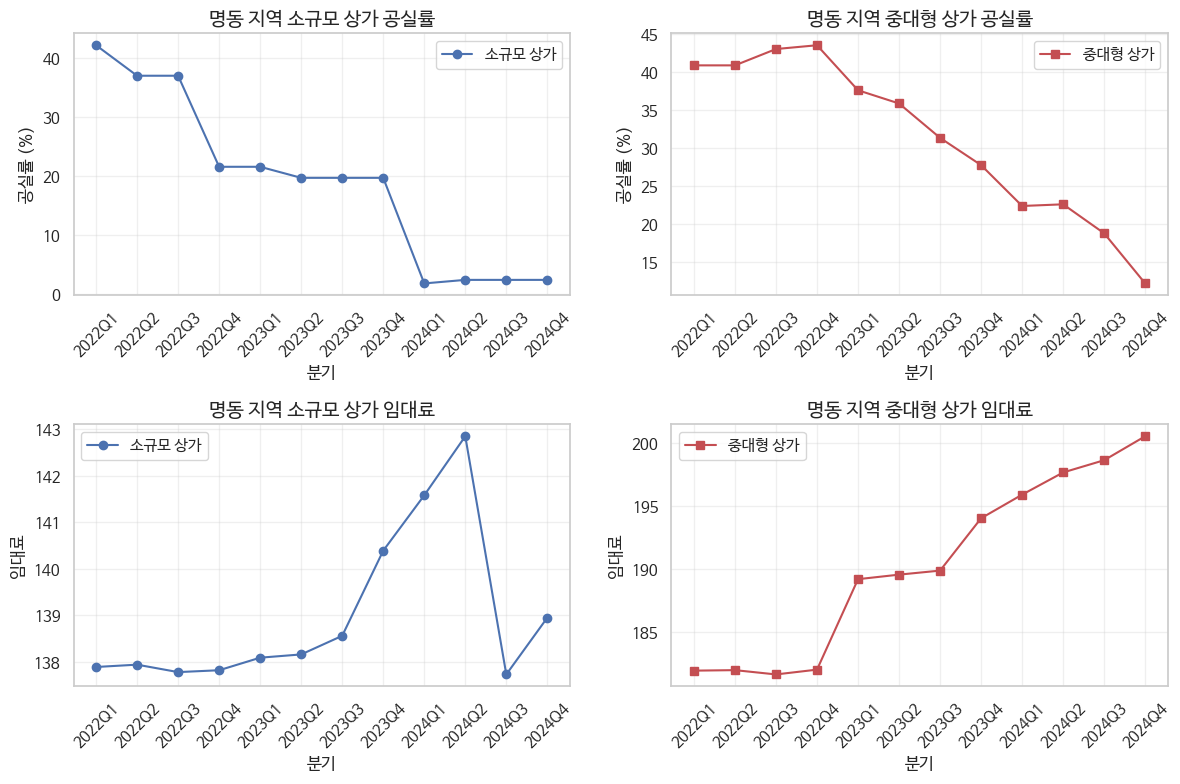

In [47]:
visualize_by_region('명동')

### 명동


- 명동은 엄청나게 공실률이 높아졌다가 현재는 점점 줄어들고 있다.
- 중대형 상가의 임대료는 지속적으로 오르고 있고, 전 세계 138개 주요 도시 상권 중 9번째로 높은 수준을 가지고 있다.
- 명동은 한때 젠트리피케이션의 영향을 받아 높은 임대료와 상권 변화로 인해 **공실률이 급증했지만, 최근에는 회복세를 보이며** 다시 상업적 활기를 되찾고 있다고 판단할 수 있다.
  [(관련 뉴스 기사 확인)](https://www.mk.co.kr/news/realestate/11175117)
  1. **외국인 관광객 증가**로 공실 감소
  2. 명동은 2023년 하반기부터 지난해 상반기까지 서울 길거리 상권 중 신규 매장이 가장 많이 오픈한 지역
- 외국인 관광객 데이터 잠깐 확인 !
  - 뉴스, 보고서 확인했을 때, 명동에 호텔이 많이 위치해있어서 자연스럽게 외국인 관광객이 많이 온다고 한다.
  - 외국인들이 가장 많이 방문하는 지역도 명동이다.


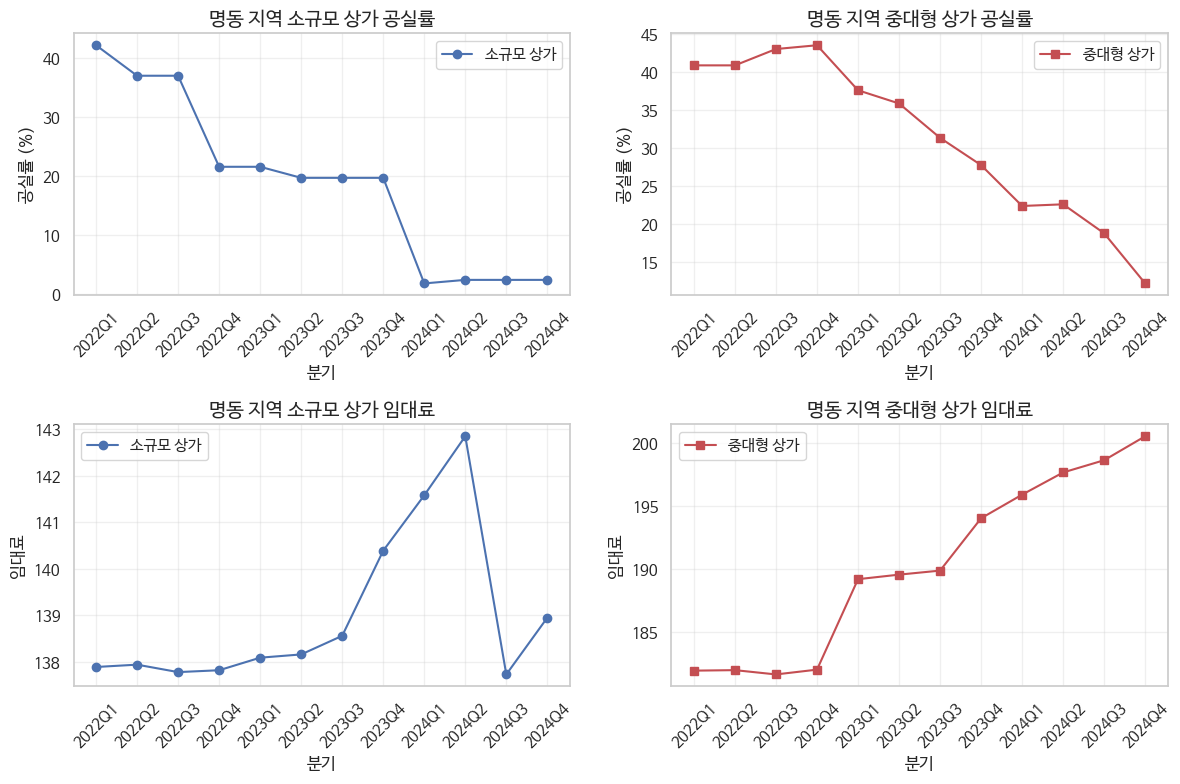

In [48]:
visualize_by_region('명동')

### 도산대로


- `소규모 상가`: 2023년부터 2024년 2분기까지 공실률 0% 유지 -> 2024년 3분기 임대료 상승 후 공실 증가 -> 4분기에 일부 공실 해소
- `중대형 상가`: 2023년 3분기 공실률 17% -> 2023년 4분기에 감소 -> 최근 임대료 상승으로 다시 8% 수준으로 증가
- 도산대로에는 흑백요리사 **셰프들의 레스토랑**이 많다! 한남동 등에서 활동하는 유명 오너셰프들이 임대료가 조금 더 낮은 도산대로로 이동했다.
  [(관련 뉴스 기사 확인)](https://www.seoul.co.kr/news/plan/seoul-fun-hip/2024/11/08/20241108030002?wlog_tag3=naver)
- 도산공원 주변으로 **플래그십 스토어**가 많이 생기고 있다.
  [(관련 뉴스 기사 확인)](https://www.mk.co.kr/news/realestate/11193386)
- 도산대로는 압구정로데오와 가까이 있다 보니 상권의 흥망성쇠가 압구정과 맞물리는 특성이 있다. 압구정과 함께 보자!
- 현재 떠오르고 있는 핫플이기 때문에 임대료가 더 오를 것으로 생각된다. 그럼 중대형 상가 공실률이 늘어날 확률이 높아진다. **젠트리피케이션 위험 수준이 다급하지는 않지만, 관찰해야할 지역으로 보인다.**


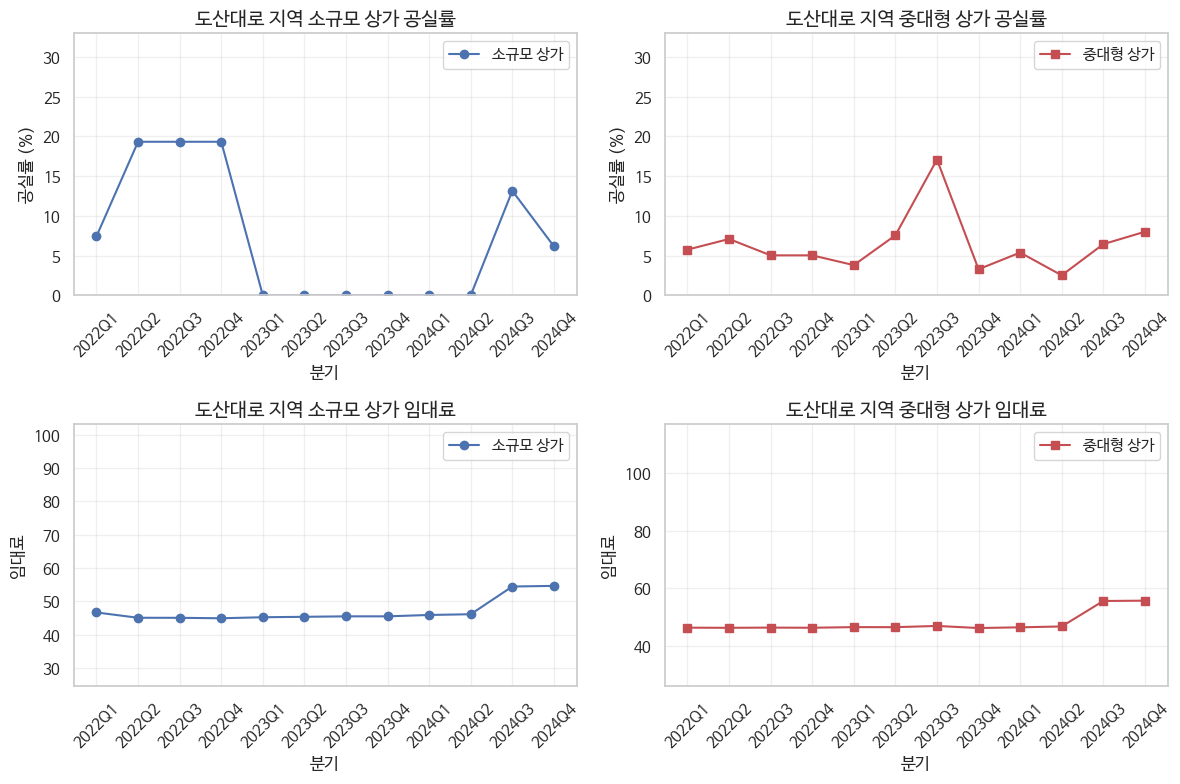

In [49]:
visualize_by_region('도산대로')

### 압구정


- 압구정은 과거 젠트리피케이션의 대표적인 사례였다.
- 현재는 **부활**한 상태..!
- 소규모 상가는 **2022년 3분기부터 공실률이 0%**이며, 중대형 상가 또한 공실률이 약 3-4%이다.
- 그러나 **임대료**는 소규모 상가와, 중대형 상가 **모두 오르는 추세**이기 때문에 제 2의 젠트리피케이션 발생 위험이 우려된다.
- 압구정 로데오거리는 과거 의류·잡화 상권이었으나 공실 증가로 인해 건물주들이 음식점 임대를 적극적으로 허용하면서 **외식업 중심지**로 변화했다.
- 유동인구 영향이 적은 외식업의 특성 덕분에 상권 활성화되었다.
- **'착한 임대료' 정책** 수행한 것도 영향이 큰 것으로 파악된다.
- 또한, **도산공원 일대의 유동인구가 증가**하고, 이곳이 포함된 압구정 상가도 영향을 받은 것으로 보인다. [(관련 뉴스 기사 확인)](https://www.mk.co.kr/economy/view/2021/657321)
- **압구정은 과거 젠트리피케이션이 발생했지만, 다시 상권이 활성화되어 젠트리피케이션을 극복했다. 하지만, 임대료가 점점 높아지는 것으로 보아 제 2의 젠트리피케이션이 일어날 수 있는 지역으로 볼 수 있다.**


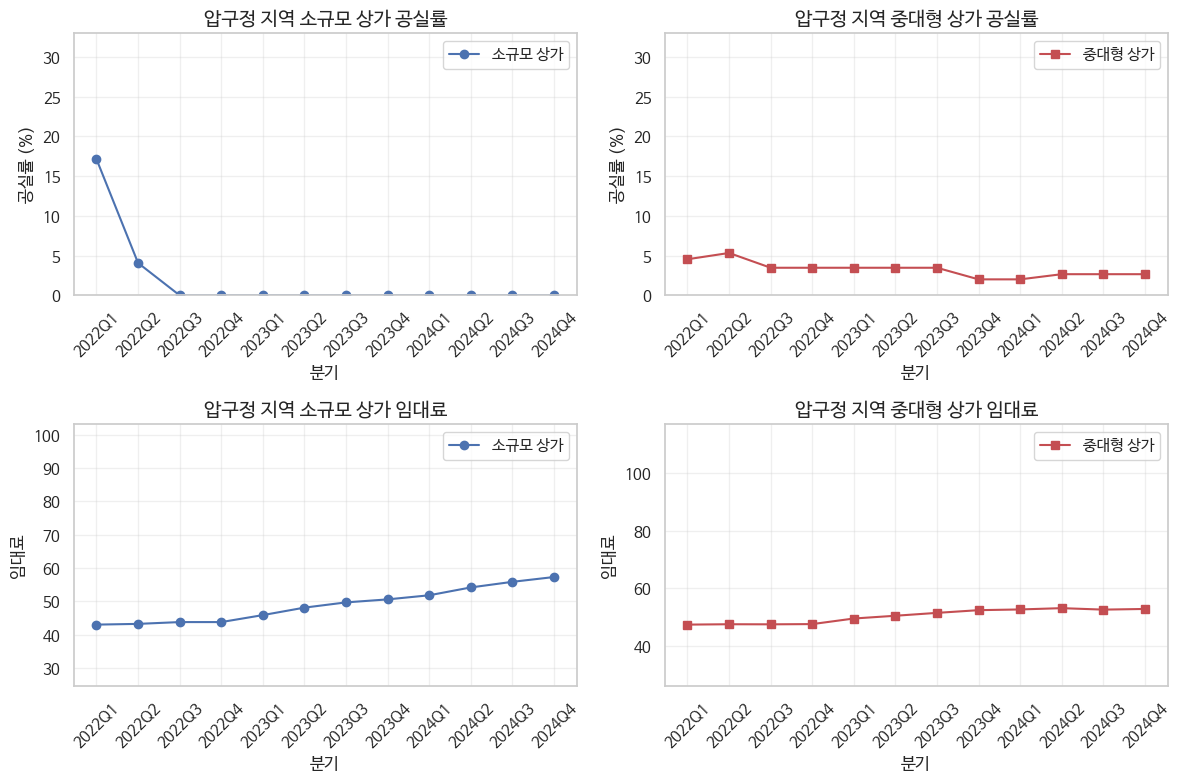

In [50]:
visualize_by_region('압구정')

### 신촌/이대


- 신촌/이대 지역의 `소규모 상가` **공실률은 2023년 2분기에 약 22%, 2024년 2분기까지도 약 18%으로 높다.**
- 2024년 3분기에는 소규모 상가의 임대료가 많이 내려가면서 공실률이 낮아진 것으로 확인된다.
- `중대형 상가` **공실률**은 2023년부터 2024년 3분기 약 14%까지 **계속해서 증가**하고있다.
- 대학가 상권에 프랜차이즈 점포들이 들어서면서 특색을 잃자, 대학가 상권으로 유입되던 젊은 세대들이 다른 곳으로 발길을 돌리고 있다.
  [(관련 뉴스 기사-1 확인)](https://www.news1.kr/society/incident-accident/5706272)
  [(관련 뉴스 기사-2 확인)](https://www.newsis.com/view/?id=NISX20240416_0002700960&cID=10401&pID=10400)
- **신촌/이대는 이미 젠트리피케이션이 진행되고 있는 지역이라고 볼 수 있다.**
- 그럼 같은 대학가인 건대입구는 어떨까? 건대입구도 확인해보자.


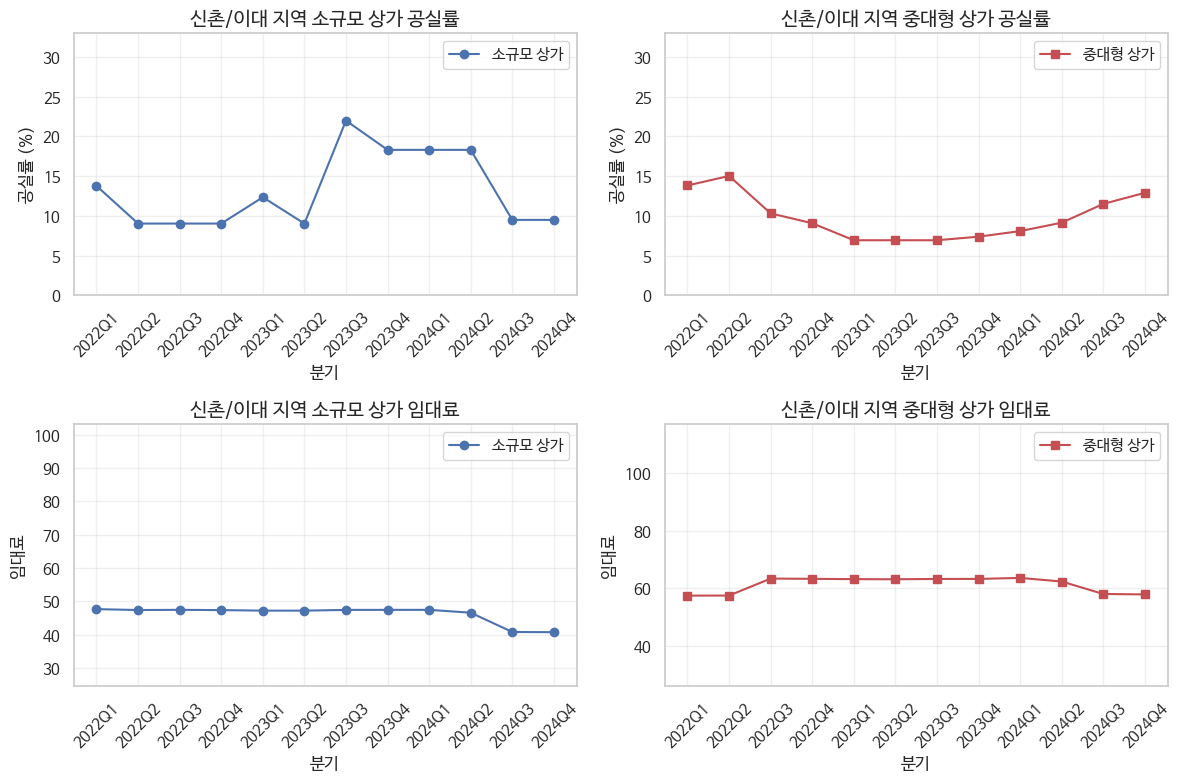

In [51]:
visualize_by_region('신촌/이대')

### 건대 입구


- 건대입구의 소규모 상가 공실률은 2023년 4분기부터 0%이다.
- 공실률이 계속 0%여서 그런지, 2024년 3분기에는 임대료를 올렸다고 파악된다.
- **중대형 상가 공실률은 임대료가 약 7만원으로, 다른 지역보다 높은 편이다.**
- 임대료를 낮추지않아서 그런지, 중대형 상가의 공실률은 2024년 2분기까지 10%까지 증가했다. 3분기에는 임대료를 낮추면서 공실률이 낮아진 것으로 보인다.
- **2024년 2분기에는 코로나19가 한창으로 공실률이 치솟았던 2020년 4분기 공실률 5.5% 보다도 높고, 2022년 1분기 4.8%에 비해서도 2배가 넘는 공실률(10%)을 기록했다.**
- 소규모 상가 공실률과 중대형 상가 공실률이 이렇게 차이나는 이유는 무엇일까? 일단, 중대형 상가 임대료가 다른 지역보다 높고, 중대형 상가는 다양한 운영 비용으로 인해 신규 임차인의 유입이 어렵기 때문으로 보여진다. 소규모 상가 공실률은 어느정도 해결된 것으로 보인다.
  [(관련 뉴스 기사 확인)](https://biz.chosun.com/real_estate/real_estate_general/2024/02/10/DNK5GVXEN5CW3ASUPBA5YATEXQ/?utm_source=naver&utm_medium=original&utm_campaign=biz)


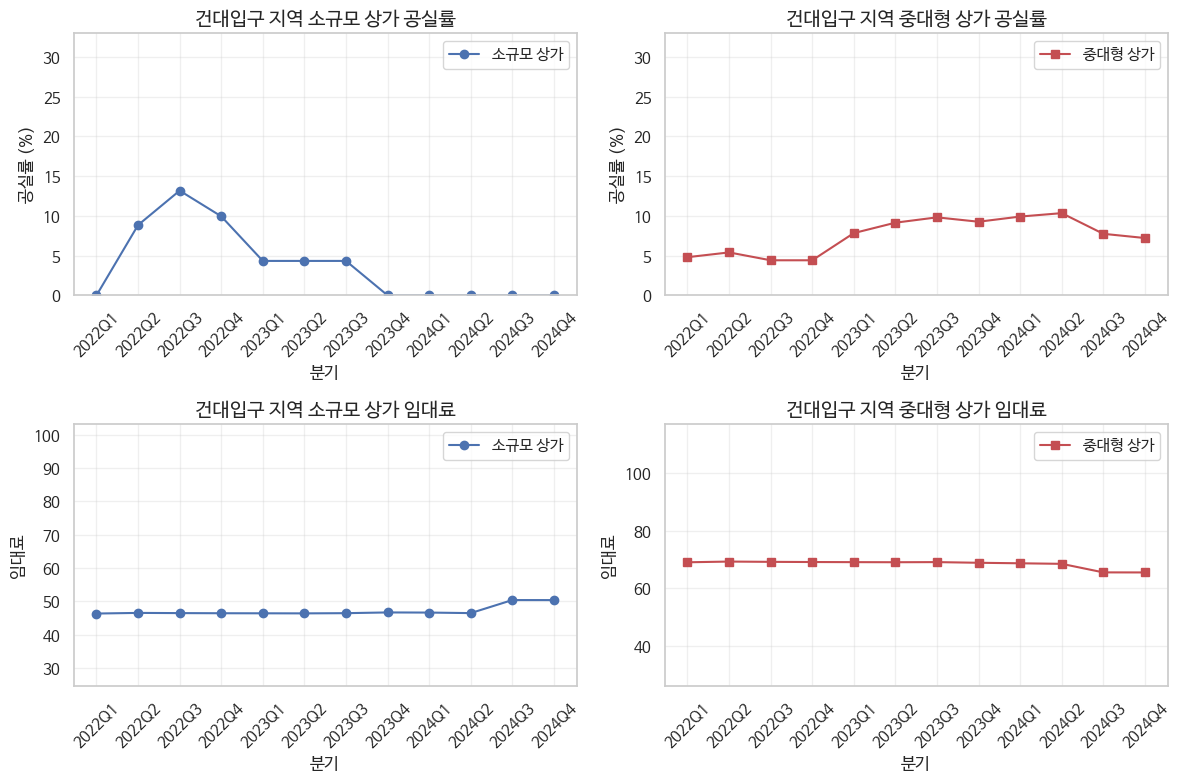

In [52]:
visualize_by_region('건대입구')

### 뚝섬 (성수동)


- 성수동은 **팝업스토어** 열풍으로 인기를 끌고 있지만, 팝업스토어 임대료가 '부르는 게 값' 수준으로 상승하면서 주변 상가 임대료도 함께 오르고 있다.
- 공실률은 낮은 편이지만, **소규모·중대형 상가 임대료가 지속적으로 상승**하고 있어 기존 상인들이 점차 밀려나는 상황이다.
- **현재 상권은 활발하지만, 젠트리피케이션 위험이 매우 높은 지역으로 보인다.**
  [(관련 뉴스 기사 확인)](https://www.ajunews.com/view/20250314165808945)


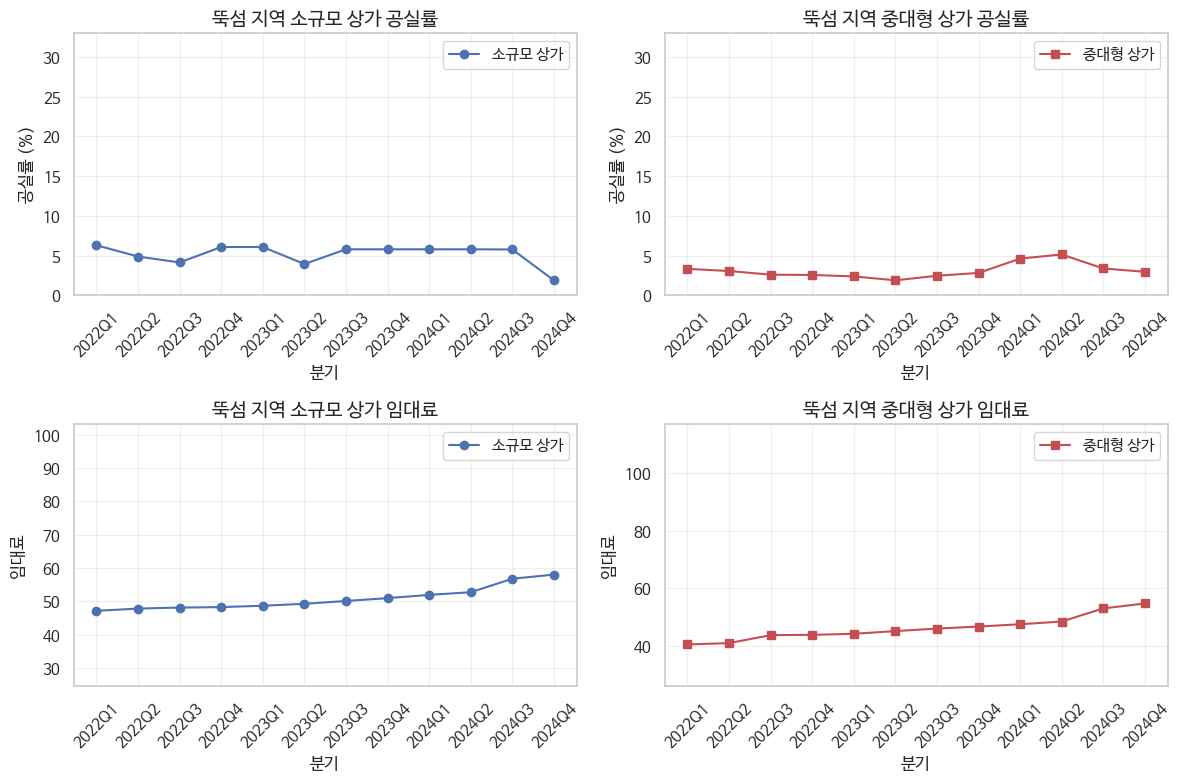

In [53]:
visualize_by_region('뚝섬')

### 신사역 (가로수길)


- 신사역 지역의 **임대료**는 소규모 상가가 m²당 약 7만원, 중대형 상가는 m²당 8-9만원으로 **매우 높다.**
- 신사역 지역의 `중대형 상가` **공실률은 모두 10% 이상으로 높은 편**이며, `소규모 상가`의 공실률은 2023년 3분기부터 5-10%로 상승하고 있다.
- 임대료 상승의 주요 원인은 **애플스토어**가 2018년 1월에 20년 치 임대료 약 600억원으로 장기 계약을 맺으면서 이후 전반적인 임대료 상승에 영향을 미친 것으로 분석된다. [(관련 뉴스 기사 확인)](https://www.hankyung.com/article/2024121689297)
- 중대형 상가의 공실률이 높아지면, 현재 소규모 상가 공실률이 낮더라도 공실률이 상승할 가능성이 있다.
- 임대료가 상승한다고 해서 공실률이 무조건 낮아지는 것은 아니다.
- **젠트리피케이션이 이미 진행되고있는 지역으로 파악된다.**


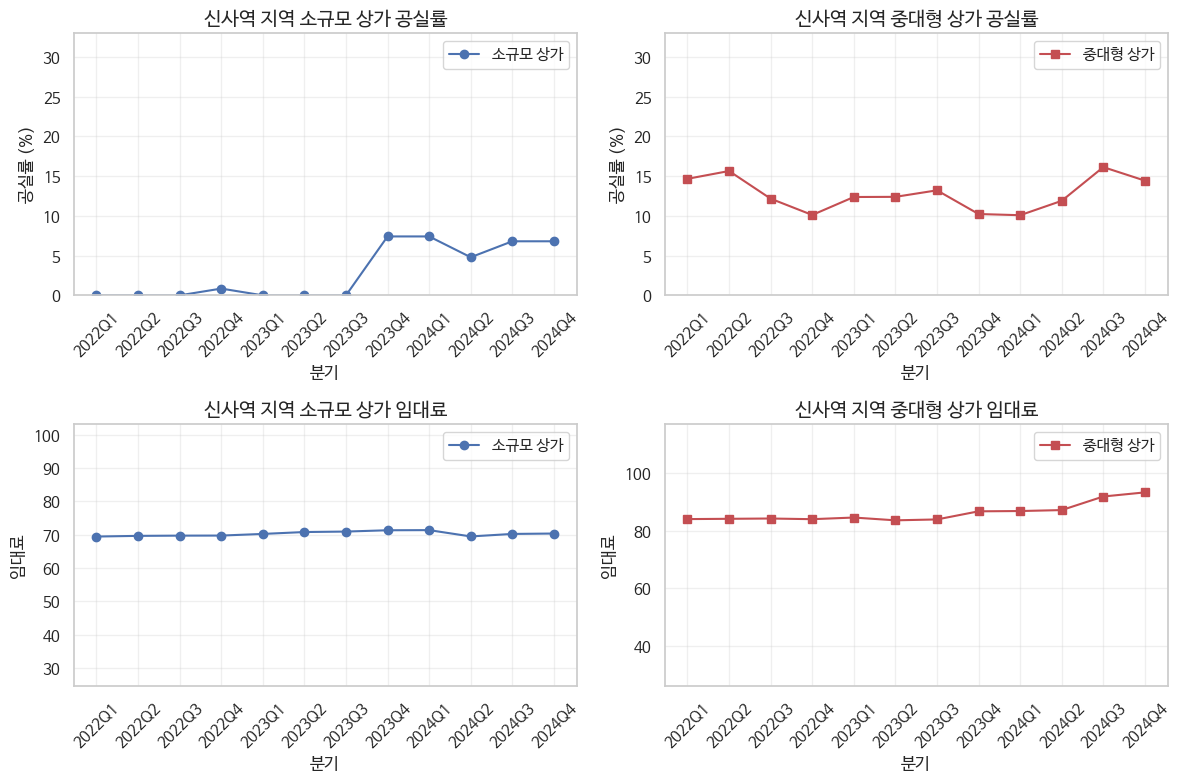

In [54]:
visualize_by_region('신사역')

### 동교/연남 (연남동)


- 소규모 상가 임대료가 m2당 5만원으로 비싼편이지만, 공실률은 5% 이하이다.
- 그러나 임대료를 조금씩 올리는 추세이다.
- 중대형 상가 공실률도 낮은 편이다.
- **비교적 안정적인 상권이라고 볼 수 있다.**


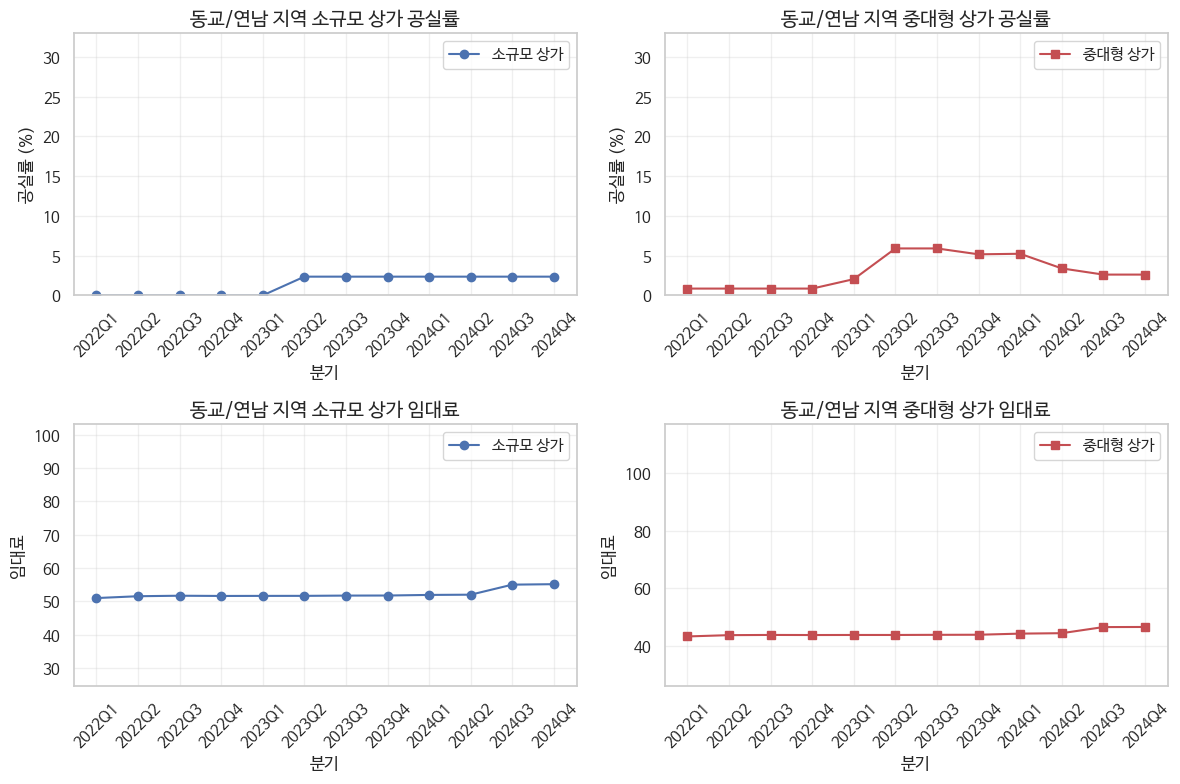

In [55]:
visualize_by_region('동교/연남')

### 망원역


- 공실률은 소규모 상가와 중대형 상가 모두 0~5%에 해당한다.
- 그러나 중대형 상가 공실률이 조금씩 늘어나는 추세이다.
- 신기하게 연남동과 같이 소규모 상가 임대료가 중대형 상가 임대료보다 높은 편이다.
- **그래도 비교적 안정적인 상권이라고 볼 수 있다.**


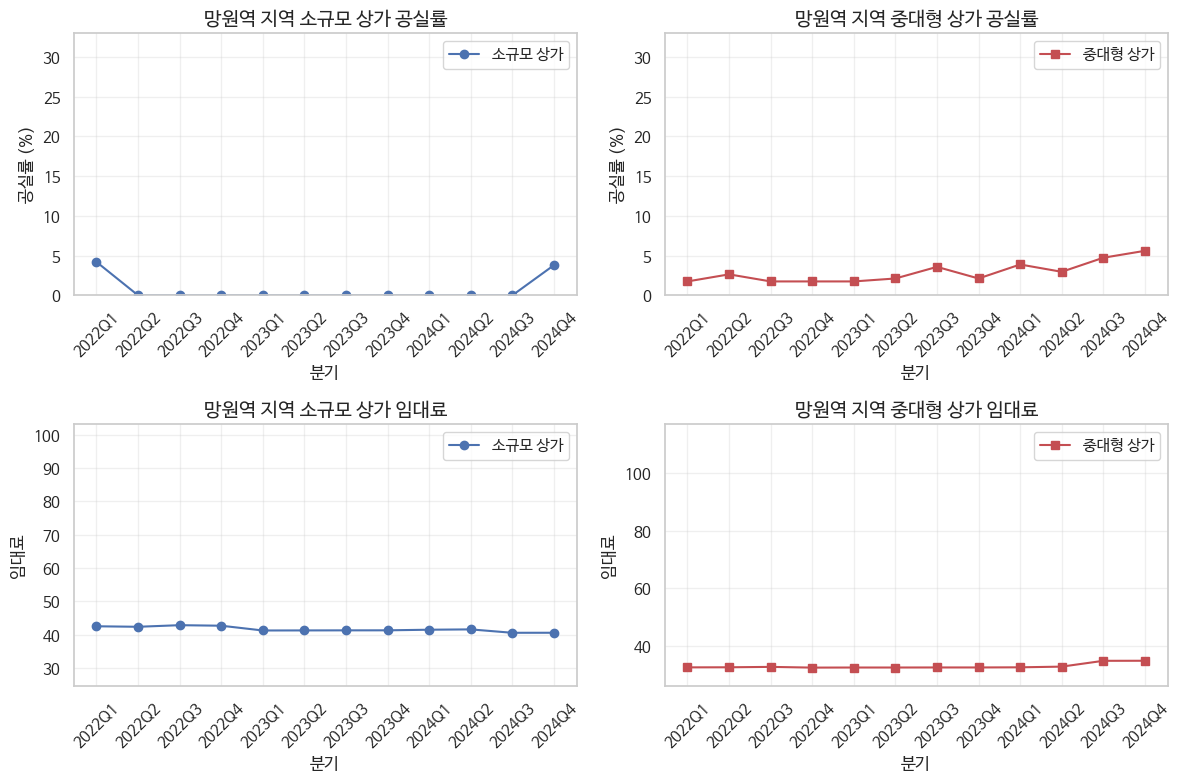

In [56]:
visualize_by_region('망원역')

### 동대문


- 공실률이 소규모 상가, 중대형 상가 모두 높게 나타난다.
- **최근 알리와 테무 등 중국이커머스가 급부상**했고 굳이 동대문까지 오는 사람들이 없어진 것으로 추측된다.[(관련 뉴스 기사 확인)](https://realty.chosun.com/site/data/html_dir/2025/03/04/2025030400469.html)
- 젠트리피케이션
- 최근 무신사스튜디오가 동대문종합시장점을 열었다.[(관련 뉴스 기사 확인)](https://www.hankyung.com/article/202503132287g)


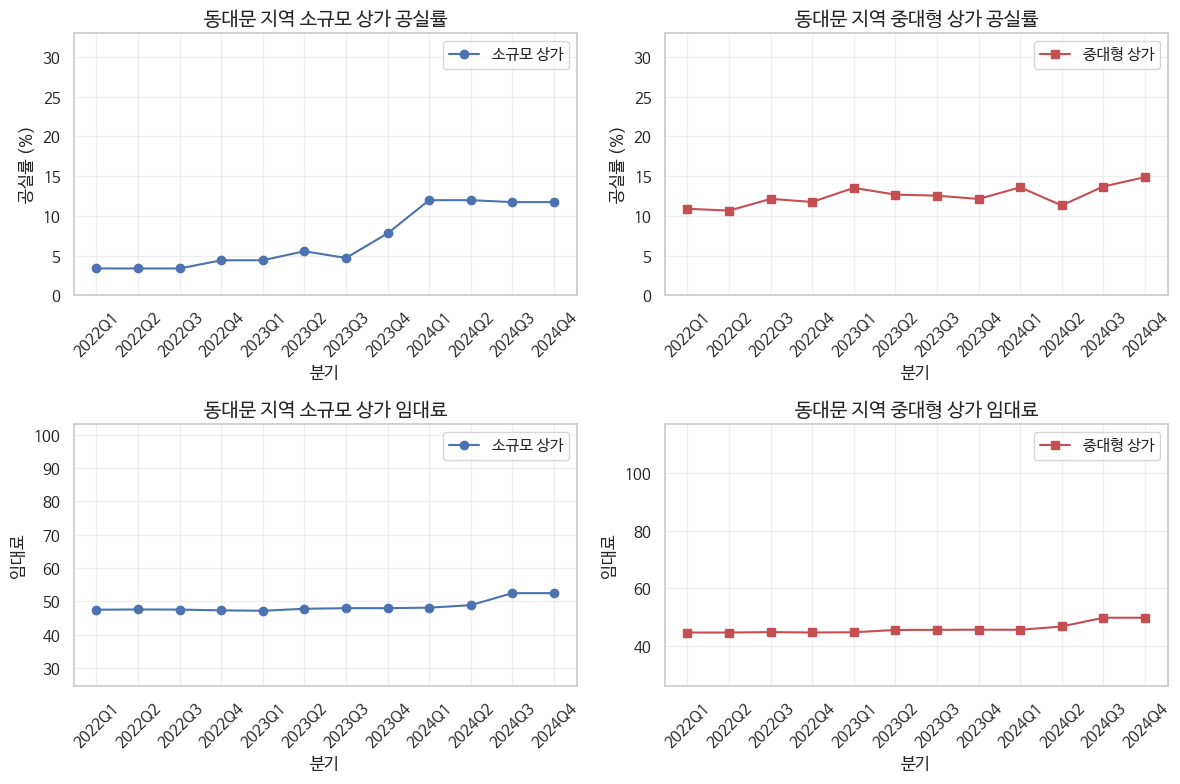

In [57]:
visualize_by_region('동대문')

### 잠실/송파 (잠실)


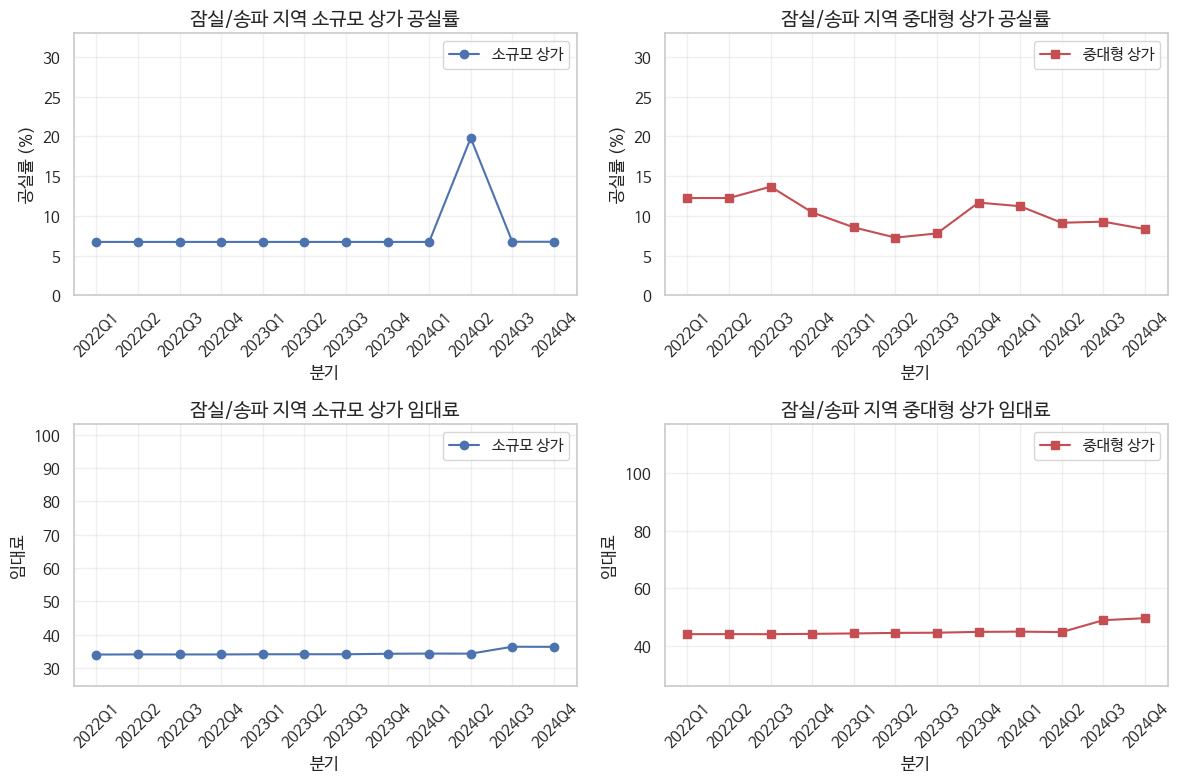

In [58]:
visualize_by_region('잠실/송파')

### 영등포역


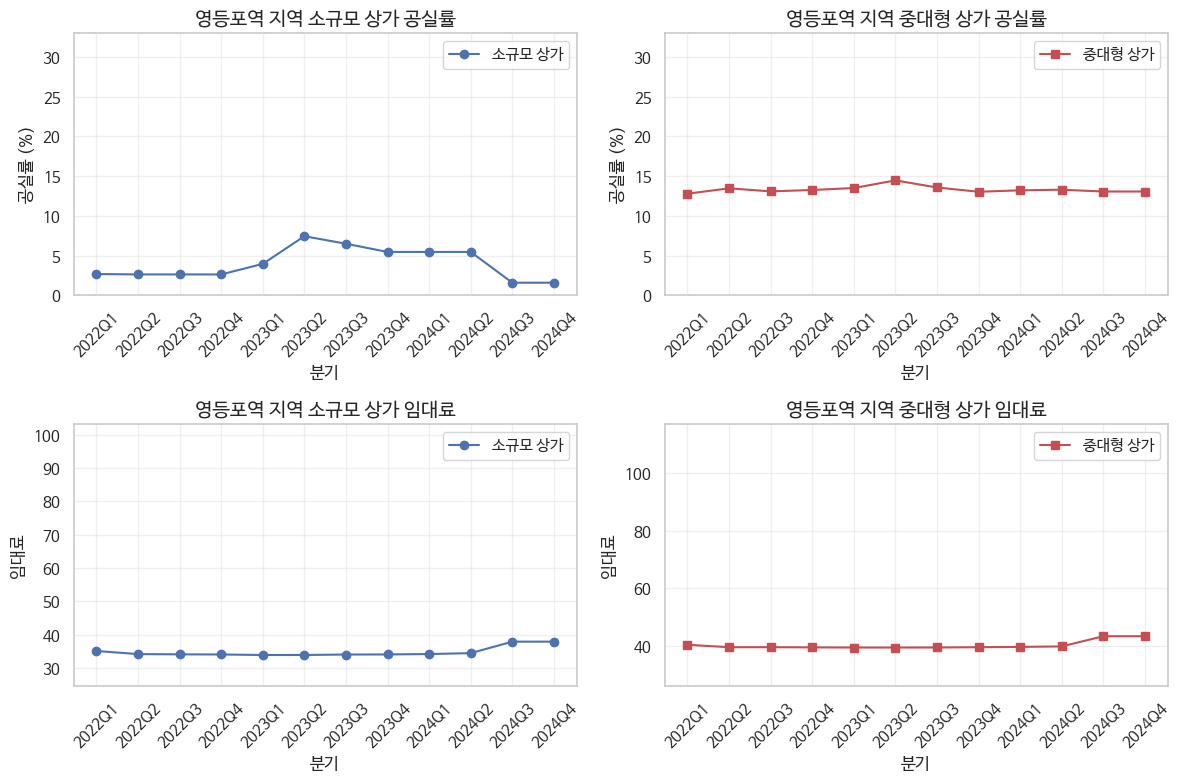

In [59]:
visualize_by_region('영등포역')

- 잠실이나 영등포의 특징은 임대료가 낮지만, 공실률은 꽤 있는 편이다.
- 임대료 상승으로 공실이 늘어나는 젠트리피케이션의 특징은 발견되지 않는다.


## 결과

- 우리가 비젠트리피케이션과 젠트리피케이션으로 정해놓은 지역이 틀린 지역도 있다.
- **공실률이 높다고해서 젠트리피케이션은 아니다.**
- **임대료가 m2당 6만원 이상이고, 공실률이 높은 지역은 이미 젠트리피케이션이 진행되고 있는 지역일 확률이 높다.**
- **임대료가 m2당 6만원 미만이고, 공실률이 높은 편인 지역은 젠트리피케이션이 아닌 다른 사유로 공실률이 높을 확률이 높다.**
- **임대료가 점점 상승하면서 공실률도 높아지고있는 지역은 젠트리피케이션에 가까워지고 있는 지역일 확률이 높다.**
- 임대료도 낮은 편이고, 공실률도 낮은 편이라면 상권이 안정적인 지역일 확률이 높다.
- **`임대료 데이터`가 굉장히 중요하다.** 결과적으로, 임대료가 높으면, 공실률이 증가할 가능성이 높고, 젠트리피케이션이 발생할 확률이 높다.

> **임대료를 읍면동별로 좀 더 세분화시켜 피쳐를 따와야할 필요가 있다고 보여진다.** <br>
> 스크래핑한 임대료 데이터를 피쳐로 사용하는 것을 생각해보자.
